# A. K-Means

## 1. Ví dụ 1

Numpy:

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial.distance import cdist 
np.random.seed(11) 
 
# Kỳ vọng và hiệp phương sai của 3 cụm dữ liệu 
means = [[2, 2], [8, 3], [3, 6]] 
cov = [[1, 0], [0, 1]] 
 
# Số điểm mỗi cụm dữ liệu 
N = 500 
 
# Tạo các cụm dữ liệu qua phân bố chuẩn (Gaussian) 
X0 = np.random.multivariate_normal(means[0], cov, N) 
X1 = np.random.multivariate_normal(means[1], cov, N) 
X2 = np.random.multivariate_normal(means[2], cov, N) 
# Tổng hợp dữ liệu từ các cụm 
X = np.concatenate((X0, X1, X2), axis = 0) 
 
# Số cụm = 3 
K = 3 
 
# Gán nhãn ban đầu cho các cụm, sau đó ta test model và so sánh 
original_label = np.asarray([0]*N + [1]*N + [2]*N).T

Visualize data:

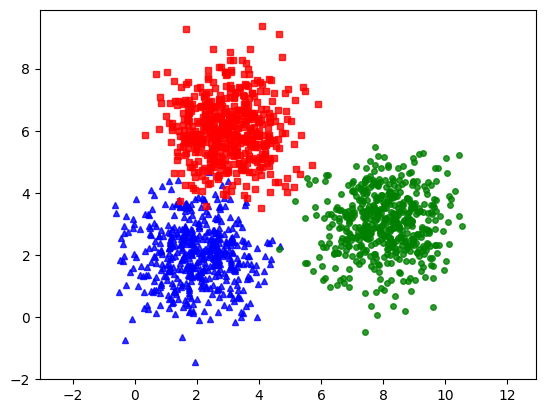

In [15]:
X0 = X[original_label == 0, :] 
X1 = X[original_label == 1, :] 
X2 = X[original_label == 2, :] 
    
plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8) 
plt.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8) 
plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize = 4, alpha = .8) 
plt.axis('equal') 
plt.plot() 
plt.show()

In [16]:
def kmeans_display(X, label, centers=None):
    K = np.amax(label) + 1  # Số cụm
    
    # Tạo màu ngẫu nhiên cho các cụm
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H']  # Các marker khác nhau cho mỗi cụm
    
    # Vẽ các điểm theo từng cụm
    for k in range(K):
        Xk = X[label == k, :]
        plt.scatter(Xk[:, 0], Xk[:, 1], 
                   c=[colors[k]], 
                   marker=markers[k % len(markers)],
                   alpha=0.6)
    
    # Vẽ các tâm cụm nếu có
    if centers is not None:
        for i in range(K):
            plt.plot(centers[i, 0], centers[i, 1], '*',
                    color='black',
                    markersize=15,
                    label=f'Centroid {i}')
    
    plt.title(f'K-means Clustering with {K} clusters')
    plt.legend()
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.show()

In [17]:
def kmeans_init_centers(X, k): 
    # randomly pick k rows of X as initial centers 
    return X[np.random.choice(X.shape[0], k, replace=False)]

In [18]:
def kmeans_assign_labels(X, centers): 
    # calculate pairwise distances btw data and centers 
    D = cdist(X, centers) 
    # return index of the closest center 
    return np.argmin(D, axis = 1)

In [19]:
def kmeans_update_centers(X, labels, K): 
    centers = np.zeros((K, X.shape[1])) 
    for k in range(K): 
        # collect all points assigned to the k-th cluster  
        Xk = X[labels == k, :] 
        # take average 
        centers[k,:] = np.mean(Xk, axis = 0) 
    return centers

In [20]:
def has_converged(centers, new_centers): 
    # return True if two sets of centers are the same 
    return (set([tuple(a) for a in centers]) ==  set([tuple(a) for a in new_centers]))

In [21]:
def kmeans(X, K): 
    centers = [kmeans_init_centers(X, K)] 
    labels = [] 
    it = 0  
    while True: 
        labels.append(kmeans_assign_labels(X, centers[-1])) 
        new_centers = kmeans_update_centers(X, labels[-1], K) 
        if has_converged(centers[-1], new_centers): 
            break 
        centers.append(new_centers) 
        it += 1 
    return (centers, labels, it)

Centers found by our algorithm:
[[2.99084705 6.04196062]
 [1.97563391 2.01568065]
 [8.03643517 3.02468432]]


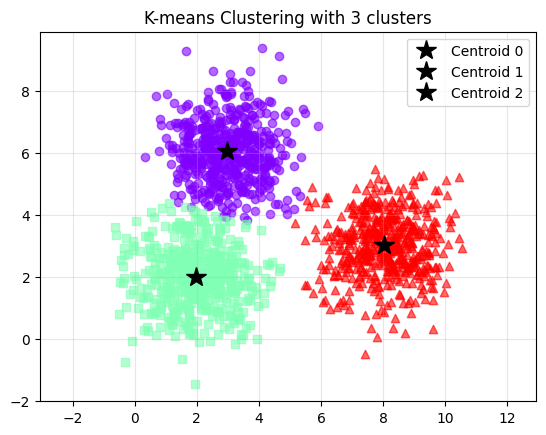

In [22]:
(centers, labels, it) = kmeans(X, K) 
print('Centers found by our algorithm:') 
print(centers[-1]) 
 
kmeans_display(X, labels[-1], centers[-1])

Sci-kit learn:

Centers found by scikit-learn:
[[1.97826939 2.00223913]
 [2.98759958 6.02896527]
 [8.0410628  3.02094748]]


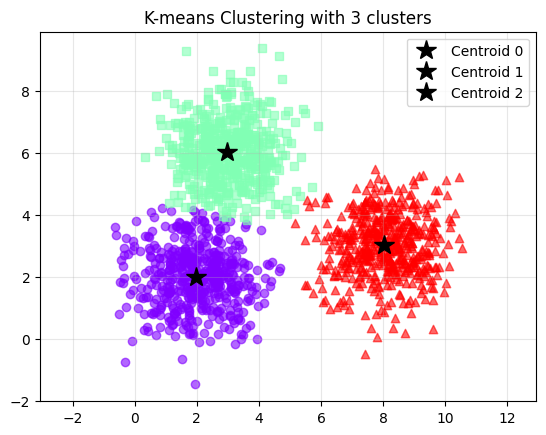

In [23]:
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=3, random_state=0).fit(X) 
print('Centers found by scikit-learn:') 
print(kmeans.cluster_centers_) 
pred_label = kmeans.predict(X) 
centroids = kmeans.cluster_centers_
kmeans_display(X, pred_label, centroids)

## 2. Ví dụ 2

In [24]:
import numpy as np  
from mnist.loader import MNIST 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.neighbors import NearestNeighbors 
from sklearn.preprocessing import normalize

def display_network(A, m = -1, n = -1): 
    opt_normalize = True 
    opt_graycolor = True 
 
    # Rescale 
    A = A - np.average(A) 
 
    # Compute rows & cols 
    (row, col) = A.shape 
    sz = int(np.ceil(np.sqrt(row))) 
    buf = 1 
    if m < 0 or n < 0: 
        n = np.ceil(np.sqrt(col)) 
        m = np.ceil(col / n) 
         
 
    image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf))) 
 
    if not opt_graycolor: 
        image *= 0.1 
 
    k = 0 
 
    for i in range(int(m)): 
        for j in range(int(n)): 
            if k >= col: 
                continue 
 
            clim = np.max(np.abs(A[:, k])) 
 
            if opt_normalize: 
                image[buf+i*(sz+buf):buf+i*(sz+buf)+sz,buf+j*(sz+buf):buf+j*(sz+buf)+sz] = A[:, k].reshape(sz, sz) / clim 
            else: 
                image[buf+i*(sz+buf):buf+i*(sz+buf)+sz,buf+j*(sz+buf):buf+j*(sz+buf)+sz] = A[:, k].reshape(sz, sz) / np.max(np.abs(A)) 
            k += 1 
 
    return image 
 
def display_color_network(A): 
    if np.min(A) >= 0: 
        A = A - np.mean(A) 
 
    cols = np.round(np.sqrt(A.shape[1])) 
 
    channel_size = A.shape[0] / 3 
    dim = np.sqrt(channel_size) 
    dimp = dim + 1 
    rows = np.ceil(A.shape[1] / cols) 
 
    B = A[0:channel_size, :]
    C = A[channel_size:2 * channel_size, :] 
    D = A[2 * channel_size:3 * channel_size, :] 
 
    B = B / np.max(np.abs(B)) 
    C = C / np.max(np.abs(C)) 
    D = D / np.max(np.abs(D)) 
 
    # Initialization of the image 
    image = np.ones(shape=(dim * rows + rows - 1, dim * cols + cols - 1, 3)) 
 
    for i in range(int(rows)): 
        for j in range(int(cols)): 
            # This sets the patch 
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 0] = B[:, i * cols + j].reshape(dim, dim) 
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 1] = C[:, i * cols + j].reshape(dim, dim) 
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 2] = D[:, i * cols + j].reshape(dim, dim) 
 
    image = (image + 1) / 2 
 
    return image

In [25]:
mndata = MNIST()
mndata.load_testing() 
X = mndata.test_images 
X0 = np.asarray(X)[:1000,:]/256.0 
X = X0 
 
K = 10 
kmeans = KMeans(n_clusters=K).fit(X) 
 
pred_label = kmeans.predict(X)

<class 'numpy.ndarray'>
(784, 10)


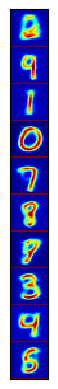

<Figure size 640x480 with 0 Axes>

In [26]:
print(type(kmeans.cluster_centers_.T)) 
print(kmeans.cluster_centers_.T.shape) 
A = display_network(kmeans.cluster_centers_.T, K, 1) 
 
f1 = plt.imshow(A, interpolation='nearest', cmap = "jet") 
f1.axes.get_xaxis().set_visible(False) 
f1.axes.get_yaxis().set_visible(False) 
plt.show() 
plt.savefig('a1.png', bbox_inches='tight') 
 
 
# a colormap and a normalization instance 
cmap = plt.cm.jet 
norm = plt.Normalize(vmin=A.min(), vmax=A.max()) 
 
# map the normalized data to colors 
# image is now RGBA (512x512x4)  
image = cmap(norm(A)) 
# plt.imshow('aa.png', image)

In [31]:
from sklearn.neighbors import NearestNeighbors

N0 = 20; 
X1 = np.zeros((N0*K, 784)) 
X2 = np.zeros((N0*K, 784)) 
 
for k in range(K): 
    Xk = X0[pred_label == k, :] 
 
    center_k = [kmeans.cluster_centers_[k]] 
    neigh = NearestNeighbors(n_neighbors=N0).fit(Xk) 
    dist, nearest_id  = neigh.kneighbors(center_k, N0) 
     
    X1[N0*k: N0*k + N0,:] = Xk[nearest_id, :] 
    X2[N0*k: N0*k + N0,:] = Xk[:N0, :]

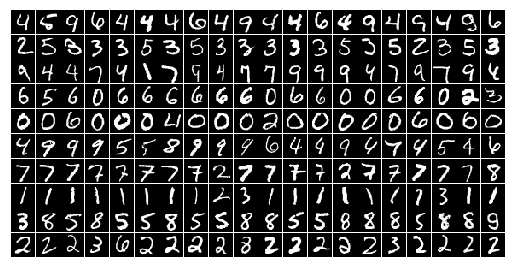

In [32]:
plt.axis('off') 
A = display_network(X2.T, K, N0) 
f2 = plt.imshow(A, interpolation='nearest' ) 
plt.gray() 
plt.show()

## Bài 1.1

In [54]:
# train path 
train_images_path = 'train-images-idx3-ubyte.gz'
train_labels_path = 'train-labels-idx1-ubyte.gz'
# test path 
test_images_path = 't10k-images-idx3-ubyte.gz'
test_labels_path = 't10k-labels-idx1-ubyte.gz'

def get_mnist_data(images_path, labels_path, num_images 
                   , shuffle=False, _is=True, image_size=28): 
    # read data 
    import gzip           # to decompress gz (zip) file 
 
    # open file training to read training data 
    f_images = gzip.open(images_path,'r') 
     
    # skip 16 first bytes because these are not data, only header infor 
    f_images.read(16) 
     
    # general: read num_images data samples if this parameter is set; 
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000) 
 
    # read all data to buf_images (28x28xreal_num) 
    buf_images = f_images.read(image_size * image_size * real_num) 
     
    # images 
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32) 
    images = images.reshape(real_num, image_size, image_size,) 
     
    # Read labels    
    f_labels = gzip.open(labels_path,'r') 
    f_labels.read(8) 
     
    labels = np.zeros((real_num)).astype(np.int64) 
     
    # rearrange to correspond the images and labels 
    for i in range(0, real_num):    
        buf_labels = f_labels.read(1) 
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64) 
     
    # shuffle to get random images data 
    if shuffle is True: 
        rand_id = np.random.randint(real_num, size=num_images) 
         
        images = images[rand_id, :] 
        labels = labels[rand_id,] 
     
    # change images data to type of vector 28x28 dimentional 
    images = images.reshape(num_images, image_size * image_size) 
    return images, labels

images, labels = get_mnist_data( 
    train_images_path, train_labels_path, 5000, shuffle=True) 
  
print(images.shape, labels.shape)

(5000, 784) (5000,)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24764\1159449395.py:39: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
transformed = pca.fit_transform(images)

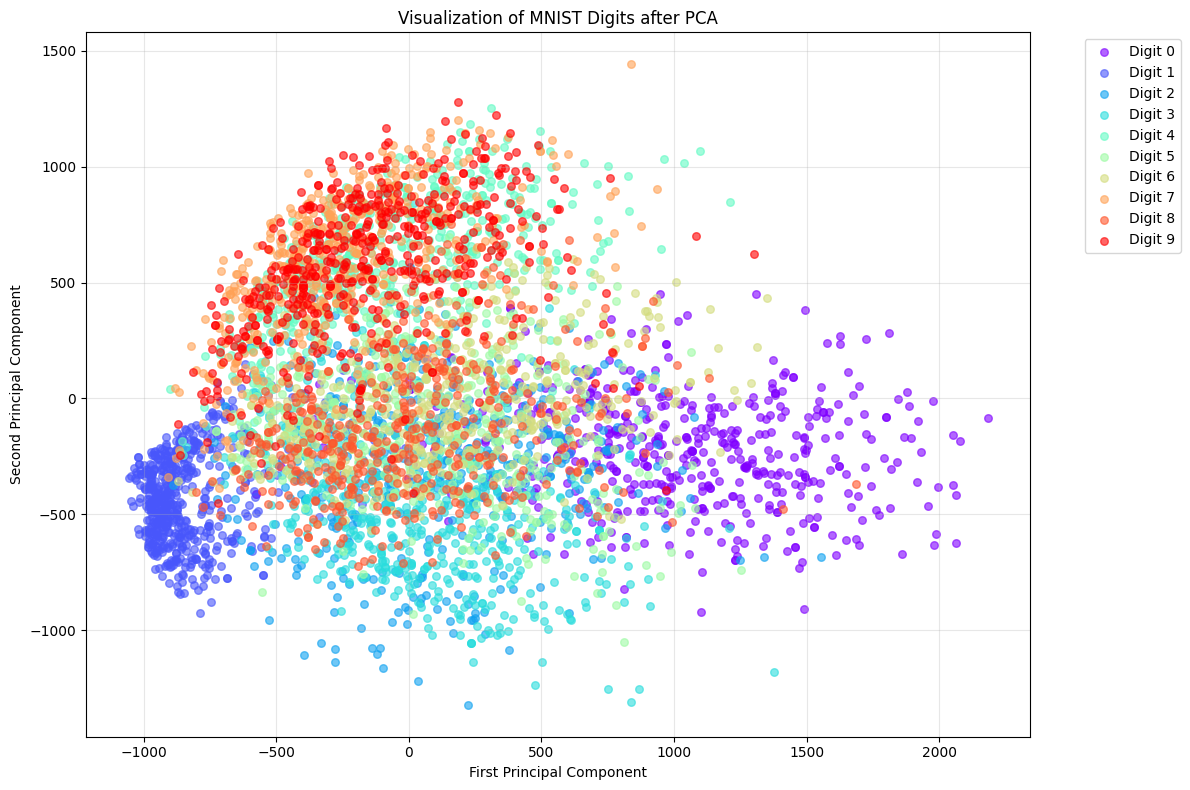

In [48]:
def visualize_all_digits(X, labels):
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Define colors for all 10 digits using rainbow colormap
    unique_labels = range(10)  # 0-9 digits
    colors = plt.cm.rainbow(np.linspace(0, 1, 10))
    
    # Plot each digit class
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        plt.scatter(X[mask, 0], X[mask, 1], 
                   c=[color], 
                   label=f'Digit {label}',
                   alpha=0.6,
                   s=30)  # s controls point size
    
    plt.title('Visualization of MNIST Digits after PCA')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize the transformed data with original labels
visualize_all_digits(transformed, labels)

Use plotly for flexibility:

In [49]:
import plotly.express as px
import pandas as pd

def interactive_digit_plot(X, labels):
    # Create DataFrame from data
    df = pd.DataFrame({
        'PC1': X[:, 0],
        'PC2': X[:, 1],
        'Digit': labels.astype(str)  # Convert to string for better legend
    })
    
    # Create interactive scatter plot
    fig = px.scatter(df, 
                    x='PC1', 
                    y='PC2',
                    color='Digit',
                    title='MNIST Digits Visualization (Click legend to filter)',
                    labels={'PC1': 'First Principal Component',
                           'PC2': 'Second Principal Component',
                           'Digit': 'Digit Class'},
                    color_discrete_sequence=px.colors.qualitative.Set3,
                    opacity=0.7)

    # Update layout
    fig.update_layout(
        legend_title_text='Click to filter:',
        title_x=0.5,  # Center title
        plot_bgcolor='white',  # White background
        width=900,
        height=600
    )

    # Add grid
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

    # Show plot
    fig.show()

# Sử dụng với dữ liệu đã transform
interactive_digit_plot(transformed, labels)

Sau khi áp dụng PCA với số chiều giữ lại là 2, ta có:
- Dữ liệu của ta có xu hướng phân thành 4 cụm khá rõ ràng: 
  - Cụm 1
  - Cụm 4,7,9
  - Cụm 2,3,5,6,8
  - Cụm 0
- Kết quả này khá tương đồng so với trước khi giảm chiều: các chữ số (4,7,9), (3,5,8), (2,3,5) thường có nhiều điểm tương đồng
- Do đó, ta sẽ áp dụng Kmeans với số cụm là 4

In [76]:
def kmeans(X, K): 
    centers = [kmeans_init_centers(X, K)] 
    labels = [] 
    it = 0  
    while True: 
        labels.append(kmeans_assign_labels(X, centers[-1])) 
        new_centers = kmeans_update_centers(X, labels[-1], K) 
        if has_converged(centers[-1], new_centers): 
            break 
        centers.append(new_centers) 
        it += 1 
    return (centers, labels, it)

Centers found by our algorithm:
[[ 981.4675293  -201.05586243]
 [ -72.26931     600.40460205]
 [-662.07348633 -274.47158813]
 [ 106.29119873 -309.48336792]]


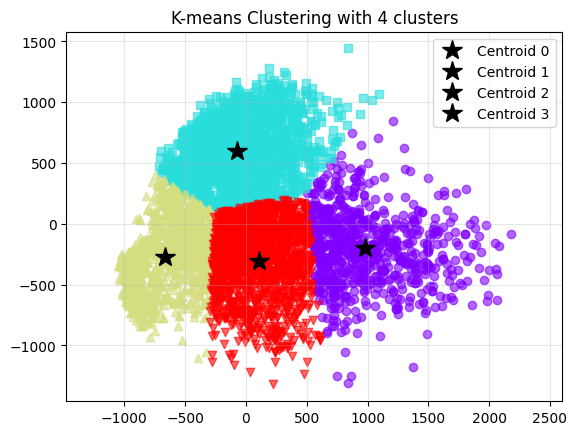

In [51]:
K = 4
(centers, labels, it) = kmeans(transformed, K) 
print('Centers found by our algorithm:') 
print(centers[-1]) 
 
kmeans_display(transformed, labels[-1], centers[-1])

- Kết quả phân cụm tương đối tốt, tuy nhiên, do Kmeans sử dụng đường trung trực giữa 2 centroid để phân biệt giữa 2 cụm nên kết quả vẫn còn khá thô
- Cluster 3 (số 0) đang bị rộng hơn so với dữ liệu trong thực tế

## Bài 1.2

In [59]:
import os

base_dir = r"C:\Users\ADMIN\OneDrive\Machine Learning\machine_learning\Lab\lab9_cnn\cats_and_dogs_filtered"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
# Change the base_dir to where you put dataset 
print("Contents of base directory:") 
print(os.listdir(base_dir)) 
 
print("\nContents of train directory:") 
print(os.listdir(train_dir)) 
 
print("\nContents of validation directory:") 
print(os.listdir(val_dir))

Contents of base directory:
['train', 'validation', 'vectorize.py']

Contents of train directory:
['cats', 'dogs']

Contents of validation directory:
['cats', 'dogs']


Flatten image:

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm  # For progress bar

def load_and_flatten_images(directory, target_size=(128, 128)):
    """
        labels: 0 for cats, 1 for dogs
    """
    images = []
    labels = []
    
    # Process each category (cats and dogs)
    for category in ['cats', 'dogs']:
        category_path = os.path.join(directory, category)
        label = 0 if category == 'cats' else 1
        
        # Get all images in the category folder
        image_files = os.listdir(category_path)
        
        # Process each image
        for image_file in tqdm(image_files):
            image_path = os.path.join(category_path, image_file)
            
            try:
                # Load and preprocess image
                img = Image.open(image_path)
                img = img.convert('RGB')  # Convert to RGB format
                img = img.resize(target_size)  # Resize image
                
                # Convert to numpy array and flatten
                img_array = np.array(img)
                flattened = img_array.reshape(-1)  # Flatten the image
                
                images.append(flattened)
                labels.append(label)
                
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")
                continue
    
    return np.array(images), np.array(labels)

# Load and flatten images from train directory
train_images, train_labels = load_and_flatten_images(train_dir)

# Print shapes to verify
print(f"\nFlattened images shape: {train_images.shape}")  # Should be (num_images, height*width*3)
print(f"Labels shape: {train_labels.shape}")  # Should be (num_images,)

# Print some statistics
print(f"\nNumber of cats: {np.sum(train_labels == 0)}")
print(f"Number of dogs: {np.sum(train_labels == 1)}")

train_images = train_images / 255.0

100%|██████████| 1000/1000 [00:10<00:00, 95.25it/s]



Flattened images shape: (2000, 49152)
Labels shape: (2000,)

Number of cats: 1000
Number of dogs: 1000


In [63]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(train_images)

KMeans(n_clusters=2)

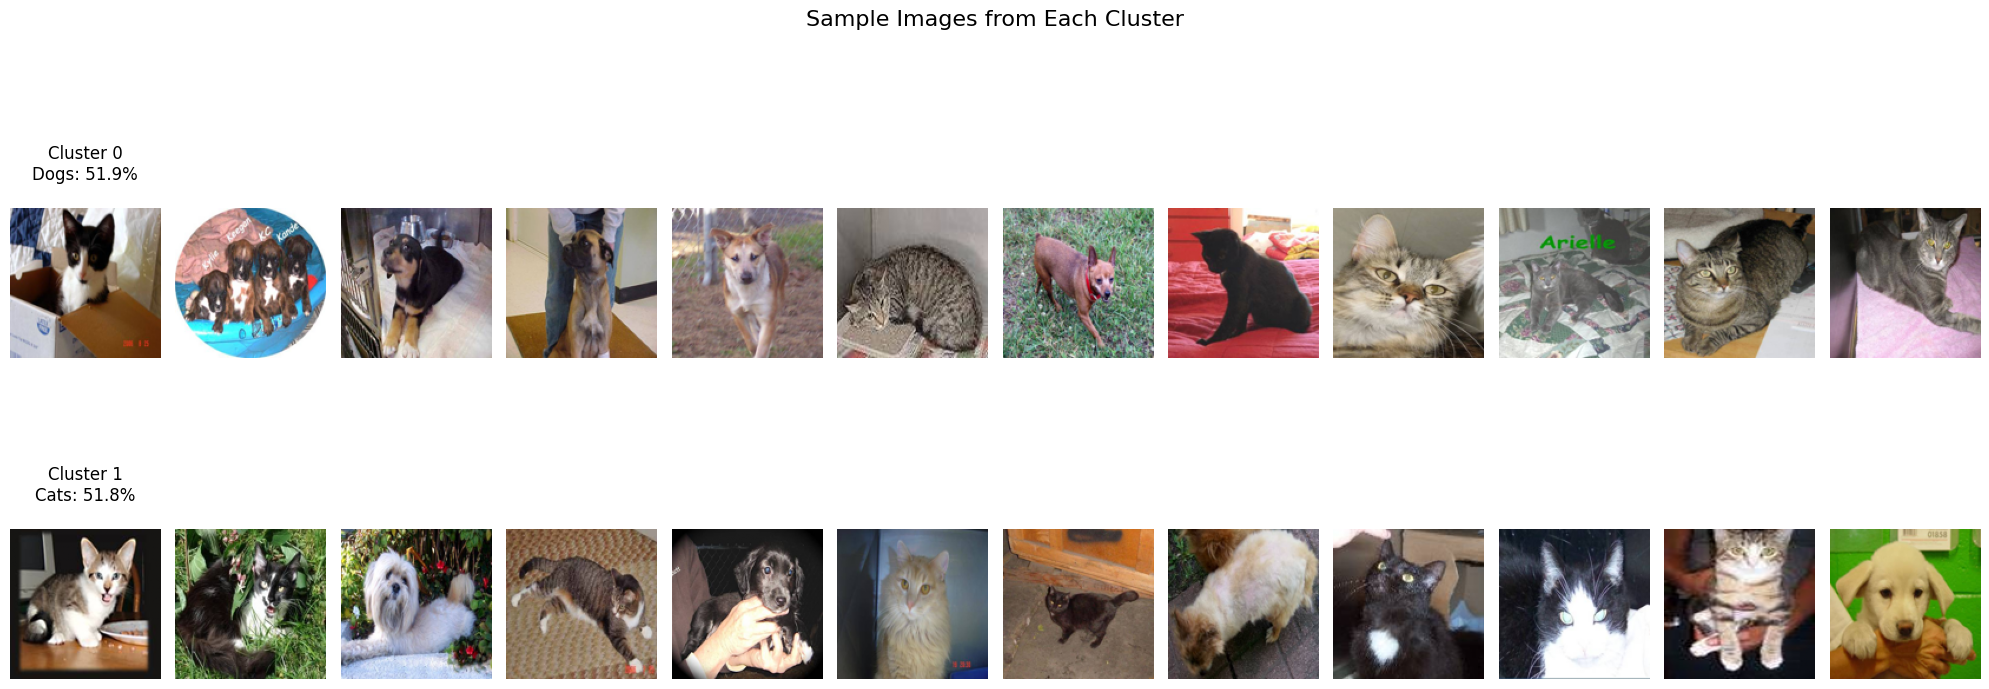

In [ ]:
def visualize_cluster_images(images, cluster_labels, num_images_per_cluster=10, target_size=(128, 128)):
    """
    Visualize representative images from each cluster
    Args:
        images: Flattened image array (n_samples, n_features)
        cluster_labels: Cluster assignments
        num_images_per_cluster: Number of images to show per cluster (default increased to 10)
        target_size: Original image dimensions (height, width)
    """
    unique_clusters = np.unique(cluster_labels)
    n_clusters = len(unique_clusters)
    
    # Create a figure with subplots for each cluster
    # Increased figure size to accommodate more images
    fig, axes = plt.subplots(n_clusters, num_images_per_cluster, 
                            figsize=(20, 4*n_clusters))
    
    # For each cluster
    for i, cluster in enumerate(unique_clusters):
        # Get indices of images in this cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]
        
        # Get cluster statistics
        cluster_size = len(cluster_indices)
        actual_cats = np.sum(train_labels[cluster_indices] == 0)
        actual_dogs = np.sum(train_labels[cluster_indices] == 1)
        purity = max(actual_cats, actual_dogs) / cluster_size
        dominant_class = 'cats' if actual_cats > actual_dogs else 'dogs'
        
        # Randomly select images from this cluster
        selected_indices = np.random.choice(cluster_indices, 
                                          size=min(num_images_per_cluster, len(cluster_indices)), 
                                          replace=False)
        
        # Plot each selected image
        for j, idx in enumerate(selected_indices):
            # Reshape flattened image back to original dimensions
            img = images[idx].reshape(target_size[0], target_size[1], 3)
            
            # Plot
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            
            # Add title to first image in row
            if j == 0:
                title = f'Cluster {cluster}\n{dominant_class.capitalize()}: {purity:.1%}'
                axes[i, j].set_title(title, pad=20)
    
    plt.suptitle('Sample Images from Each Cluster', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_cluster_images(
    train_images, 
    kmeans.labels_,
    num_images_per_cluster=12, 
    target_size=(128, 128)
)

- Kết quả phân cụm chưa được tốt, cả 2 cụm đều chứa số lượng chó và mèo khá tương đồng nhau

#### Try with PCA:

In [69]:
pca = PCA(n_components=2)
transformed = pca.fit_transform(train_images)

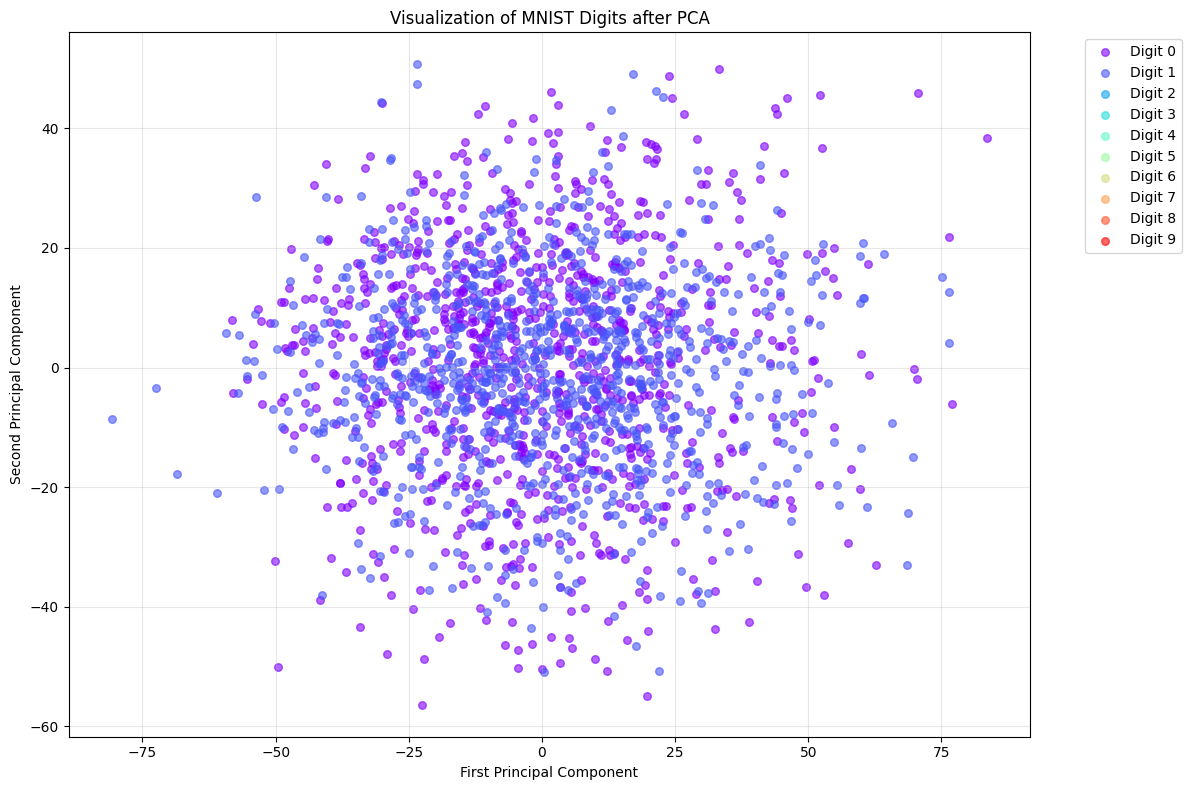

In [73]:
def visualize_all(X, labels):
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Define colors for all 10 digits using rainbow colormap
    unique_labels = range(10)  # 0-9 digits
    colors = plt.cm.rainbow(np.linspace(0, 1, 10))
    
    # Plot each digit class
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        plt.scatter(X[mask, 0], X[mask, 1], 
                   c=[color], 
                   label=f'Digit {label}',
                   alpha=0.6,
                   s=30)  # s controls point size
    
    plt.title('Visualization of MNIST Digits after PCA')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize the transformed data with original labels
visualize_all(transformed, train_labels)

Centers found by our algorithm:
[[ 20.35782397   0.18573232]
 [-18.60451856  -0.16973624]]


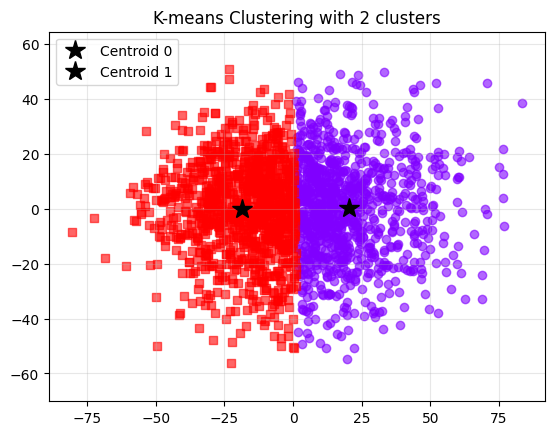

In [77]:
K = 2
(centers, labels, it) = kmeans(transformed, K) 
print('Centers found by our algorithm:') 
print(centers[-1]) 
 
kmeans_display(transformed, labels[-1], centers[-1])

- Đúng như dự đoán, do dữ liệu có sự chồng lấn mạnh nên Kmeans không thể cho ra kết quả tốt

# B. DBScan

In [82]:
import numpy as np
from matplotlib import pyplot as plt

class DBSCAN(object):

    def __init__(self,x,epsilon,minpts):
        # The number of input dataset
        self.n = len(x)
        # Euclidean distance
        p, q = np.meshgrid(np.arange(self.n), np.arange(self.n))
        self.dist = np.sqrt(np.sum(((x[p] - x[q])**2),2))
        # label as visited points and noise
        self.visited = np.full((self.n), False)
        self.noise = np.full((self.n),False)
        # DBSCAN Parameters
        self.epsilon = epsilon
        self.minpts = minpts
        # Cluseter
        self.idx = np.full((self.n),0)
        self.C = 0
        self.input = x

    def run(self):
        # Clustering
        for i in range(len(self.input)):
            if self.visited[i] == False:
                self.visited[i] = True
                self.neighbors = self.regionQuery(i)
                if len(self.neighbors) >= self.minpts:
                    self.C += 1
                    self.expandCluster(i)
                else : self.noise[i] = True
        return self.idx,self.noise

    def regionQuery(self, i):
        g = self.dist[i,:] < self.epsilon
        Neighbors = np.where(g)[0].tolist()
        return Neighbors

    def expandCluster(self, i):
        self.idx[i] = self.C
        k = 0
       
        while True:
            if len(self.neighbors) <= k:return
            j = self.neighbors[k]
            if self.visited[j] != True:
                self.visited[j] = True

                self.neighbors2 = self.regionQuery(j)
                v = [self.neighbors2[i] for i in np.where(self.idx[self.neighbors2]==0)[0]]

                if len(self.neighbors2) >=  self.minpts:
                    self.neighbors = self.neighbors+v

            if self.idx[j] == 0 : self.idx[j] = self.C
            k += 1

    def sort(self):
        
        cnum = np.max(self.idx)
        self.cluster = []
        self.noise = []
        for i in range(cnum):
           
            k = np.where(self.idx == (i+1))[0].tolist()
            self.cluster.append([self.input[k,:]])
       
        self.noise = self.input[np.where(self.idx == 0)[0].tolist(),:]
        return self.cluster, self.noise

    def plot(self):
        
        self.sort()
        fig,ax = plt.subplots()
        
        for idx,group in enumerate(self.cluster):
        
            ax.plot(group[0][:,0],
                    group[0][:,1],
                    marker='o',
                    linestyle='',
                    label='Cluster {}'.format(idx))

            if self.noise != None:
                ax.plot(self.noise[:,0],
                    self.noise[:,1],
                    marker='x',
                    linestyle='',
                    label='noise')

        ax.legend(fontsize=10, loc='upper left')
        plt.title('Scatter Plot of Clustering result', fontsize=15)
        plt.xlabel('X', fontsize=14)
        plt.ylabel('Y', fontsize=14)
        plt.show()

## Bài 2.1

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24764\4019189338.py:85: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



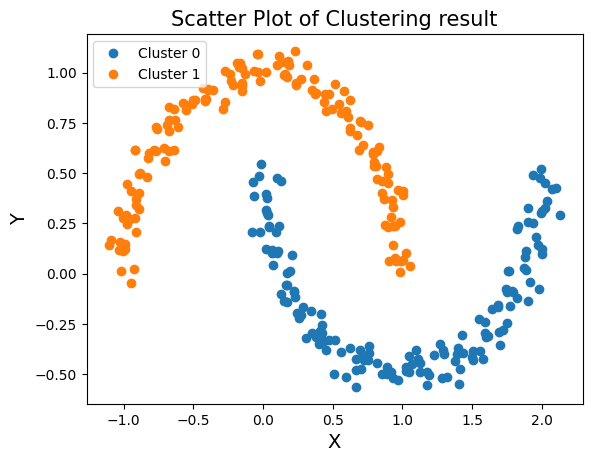

In [83]:
from sklearn.datasets import make_moons

X, _ = make_moons(n_samples=300, noise=0.05, random_state=42)

# INIT DBSCAN
dbscan = DBSCAN(X, 0.3, 5)
# CLUSTERING
idx,noise = dbscan.run()
# SORTING
g_cluster,n_cluster = dbscan.sort()
# Visualization
dbscan.plot()

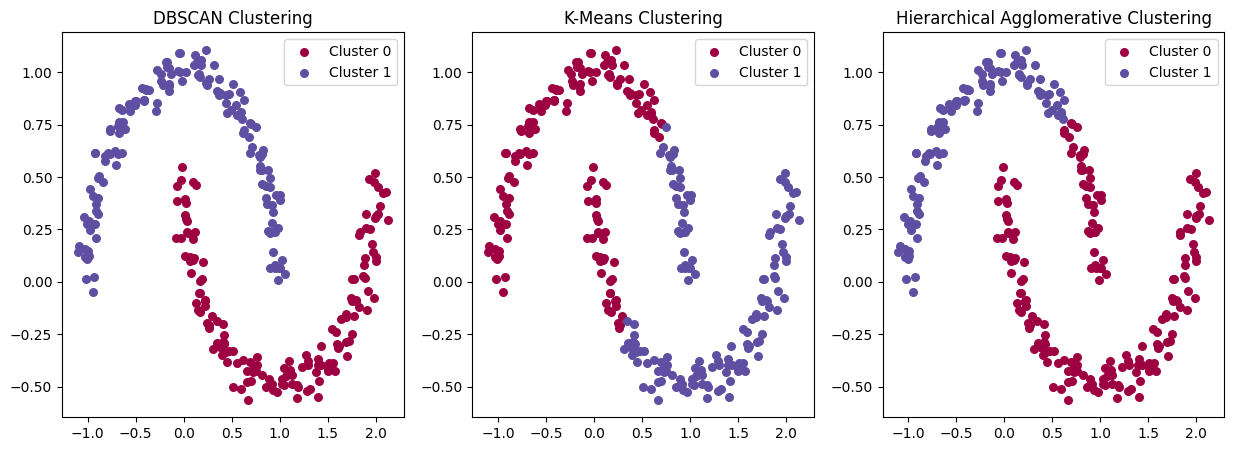

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.datasets import make_moons

# Generate synthetic data (you can replace this with your own data)
X, _ = make_moons(n_samples=300, noise=0.05, random_state=42)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Apply Hierarchical Agglomerative Clustering (HAC)
hac = AgglomerativeClustering(n_clusters=2)
hac_labels = hac.fit_predict(X)

# Plot the results for DBSCAN
plt.figure(figsize=(15, 5))

plt.subplot(131)
unique_labels_dbscan = np.unique(dbscan_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels_dbscan)))

for label, color in zip(unique_labels_dbscan, colors):
    if label == -1:
        plt.scatter(X[dbscan_labels == label][:, 0], X[dbscan_labels == label][:, 1], color='gray', s=10, label='Noise')
    else:
        plt.scatter(X[dbscan_labels == label][:, 0], X[dbscan_labels == label][:, 1], color=color, s=30, label=f'Cluster {label}')

plt.title('DBSCAN Clustering')
plt.legend()

# Plot the results for K-Means
plt.subplot(132)
unique_labels_kmeans = np.unique(kmeans_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels_kmeans)))

for label, color in zip(unique_labels_kmeans, colors):
    plt.scatter(X[kmeans_labels == label][:, 0], X[kmeans_labels == label][:, 1], color=color, s=30, label=f'Cluster {label}')

plt.title('K-Means Clustering')
plt.legend()

# Plot the results for HAC
plt.subplot(133)
unique_labels_hac = np.unique(hac_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels_hac)))

for label, color in zip(unique_labels_hac, colors):
    plt.scatter(X[hac_labels == label][:, 0], X[hac_labels == label][:, 1], color=color, s=30, label=f'Cluster {label}')

plt.title('Hierarchical Agglomerative Clustering')
plt.legend()

plt.show()

## Bài 2.2

In [1]:
import pandas as pd

def make_data(data_path):
    df = pd.read_csv(data_path)
    df.drop(['Product_Code', 'MIN', 'MAX'], axis=1, inplace=True)
    for c in df.columns:
        if c.find('Normalized') >= 0:
            df.drop(c, axis=1, inplace=True)
    return df
data = make_data('Sales_Transactions_Dataset_Weekly.csv')
data.head()

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,11,12,10,8,13,12,14,21,6,14,...,4,7,8,10,12,3,7,6,5,10
1,7,6,3,2,7,1,6,3,3,3,...,2,4,5,1,1,4,5,1,6,0
2,7,11,8,9,10,8,7,13,12,6,...,6,14,5,5,7,8,14,8,8,7
3,12,8,13,5,9,6,9,13,13,11,...,9,10,3,4,6,8,14,8,7,8
4,8,5,13,11,6,7,9,14,9,9,...,7,11,7,12,6,6,5,11,8,9


KMeans:

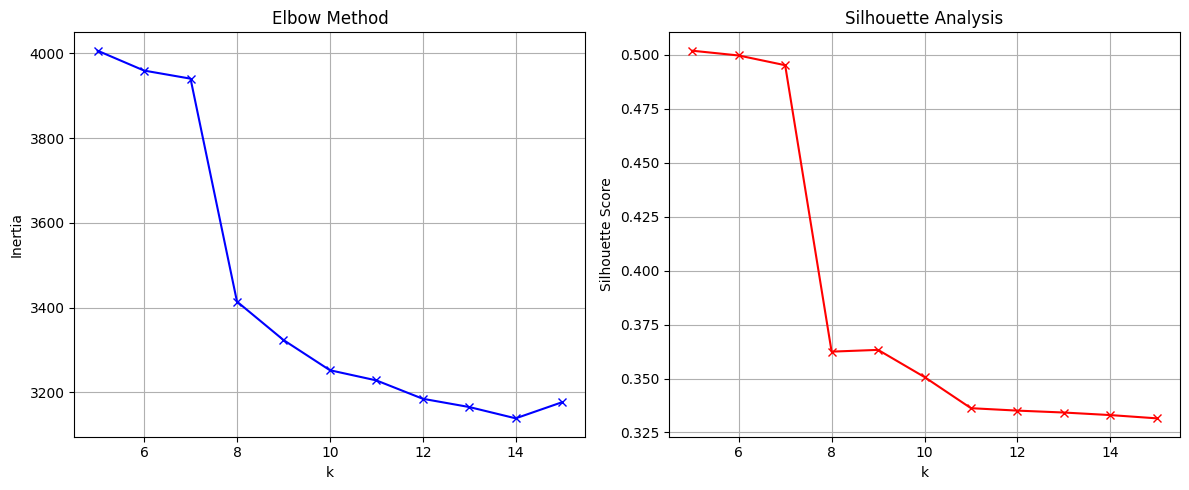

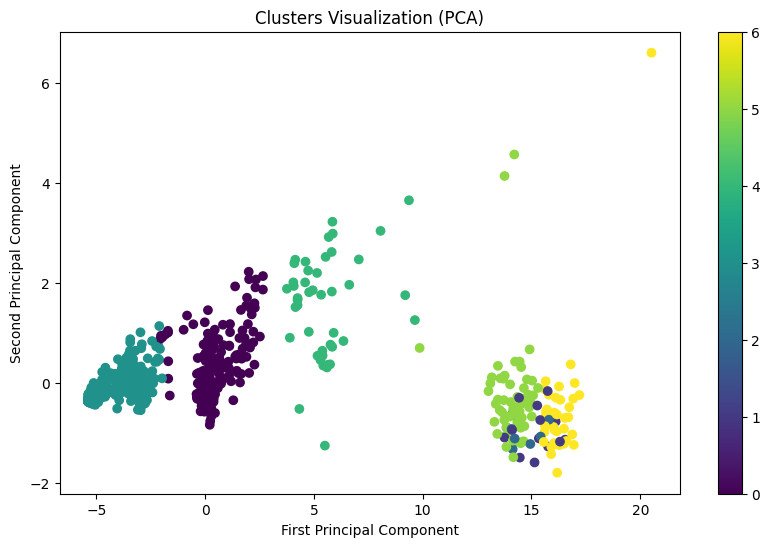

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X = data.to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# calculate inertia and silhouette scores for different K values
inertias = []
silhouette_scores = []
K_range = range(5, 16)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

# plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)
plt.tight_layout()
plt.show()

# find optimal K (example: k=7 based on plots)
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# visualize cluster patterns using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('Clusters Visualization (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()